In [6]:
from cProfile import label
from os import times
from tokenize import cookie_re
from xmlrpc.client import boolean
from numpy.core.shape_base import atleast_2d
from numpy.lib import type_check
from scipy import fftpack
import math
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy import signal


# "HPC" -> no graph
# "LOCAL" -> graph

# detects the first downward zerocross point


def getDownwardZeroCrossIndex(vector1d):
    downCount = 0
    searchIndex = 1
    """
    for i in range(10):
        #downcount counter until datapoint 10
        searchIndex = searchIndex + i
        if data[searchIndex] - data[searchIndex-1] < 0:
            downCount=downCount + 1
        else:
            downCount = 0
    """
    while True:
        searchIndex = searchIndex + 1
        if vector1d[searchIndex] < 0 and vector1d[searchIndex-1] > 0:
            for i in range(10):
                if vector1d[searchIndex-5+i] < vector1d[searchIndex-5+i+1]:
                    downCount = 0
                else:
                    downCount = downCount+1
            if downCount == 10:
                # print(searchIndex)
                return searchIndex

# detects the first upward zerocross point


def getUpwardZeroCrossIndex(vector1d):
    upCount = 0
    searchIndex = 1
    """
    for i in range(10):
        #downcount counter until datapoint 10
        searchIndex = searchIndex + i
        if data[searchIndex] - data[searchIndex-1] < 0:
            upCount=upCount + 1
        else:
            upCount = 0
    """
    while True:
        searchIndex = searchIndex + 1
        if vector1d[searchIndex] > 0 and vector1d[searchIndex-1] < 0:
            for i in range(10):
                if vector1d[searchIndex-5+i] > vector1d[searchIndex-5+i+1]:
                    upCount = 0
                else:
                    upCount = upCount+1
            if upCount == 10:
                # print(searchIndex)
                return searchIndex


def getDownwardZeroCrossIndexFromArbitraryPoint(vector1d, startIndex):
    downCount = 0
    searchIndex = startIndex
    """
    for i in range(10):
        #downcount counter until datapoint 10
        searchIndex = searchIndex + i
        if data[searchIndex] - data[searchIndex-1] < 0:
            downCount=downCount + 1
        else:
            downCount = 0
    """
    while True:
        searchIndex = searchIndex + 1
        if vector1d[searchIndex] < 0 and vector1d[searchIndex-1] > 0:
            for i in range(10):
                if vector1d[searchIndex-5+i] < vector1d[searchIndex-5+i+1]:
                    downCount = 0
                else:
                    downCount = downCount+1
            if downCount == 10:
                # print(searchIndex)
                return searchIndex


def getUpwardZeroCrossIndexFromArbitraryPoint(vector1d, startIndex):
    """Searches for an upward zerocross point from the specified index of the vector."""
    upCount = 0
    searchIndex = startIndex
    """
    for i in range(10):
        #downcount counter until datapoint 10
        searchIndex = searchIndex + i
        if data[searchIndex] - data[searchIndex-1] < 0:
            upCount=upCount + 1
        else:
            upCount = 0
    """
    while True:
        searchIndex = searchIndex + 1
        if vector1d[searchIndex] > 0 and vector1d[searchIndex-1] < 0:
            for i in range(10):
                if vector1d[searchIndex-5+i] > vector1d[searchIndex-5+i+1]:
                    upCount = 0
                else:
                    upCount = upCount+1
                if upCount == 10:
                    # print(searchIndex)
                    return searchIndex


# Reads the csv file where time series data of detector coorinate is saved.
def loadCsvOutput(csvData):
    """Reads the outp.csv file and covert it into ndarray."""
    ndarrayData = np.loadtxt(csvData, delimiter=",")

    # Several timesteps are recorded twice in the raw csv file.
    # Below is the script which deletes the double-recorded timesteps.
    timeAtTheRowAbove = -100
    delRows = []
    for i in range(len(ndarrayData)):
        if timeAtTheRowAbove == ndarrayData[i, 0]:
            delRows.append(i)
        timeAtTheRowAbove = ndarrayData[i, 0]
    ndarrayData = np.delete(ndarrayData, delRows, 0)

    return ndarrayData

# Withdraws the time series of the detector's x coorinate


def getDetector(array):
    return array[:, 2]

# Withdraws the time series of the source's x coorinate


def getSource(array):
    return array[:, 1]

# trims the wave within the specified range


def trim(vector1d, trimStartTimestep, trimRange):
    trimmedArray = vector1d[trimStartTimestep:trimStartTimestep+trimRange]
    return trimmedArray

# trims the wave within the specified range and then offsets the wave so that the normal position can be x=0.


def trimAndOffset(vector1d, trimStartTimestep, trimRange):
    trimmedArray = vector1d[trimStartTimestep:trimStartTimestep+trimRange]
    offsettedArray = trimmedArray - vector1d[0]
    return offsettedArray

# performs fft. output[0] = power, output[1] = freq. both output are recognized as complex.


def fftWithWindow(FFTData, hannORhamming: str, dt):
    dataPoints = len(FFTData)
    if hannORhamming == "hann":
        windowFunction = signal.hann(dataPoints)
    elif hannORhamming == "hamming":
        windowFunction = signal.hamming(dataPoints)
    else:
        raise Exception(
            "Window is not/wrongly specified. Either hann / hamming is right.")
    acf = 1/(sum(windowFunction)/dataPoints)
    # print("acf")
    # print(acf)
    waveToTransform = acf*windowFunction*FFTData
    FFT_power = np.fft.fft(waveToTransform, n=None, norm=None)
    FFT_freq = np.fft.fftfreq(dataPoints, d=dt*(10**-12))
    return np.stack([FFT_power, FFT_freq])

# under development


def window(data, hannORhamming: str):
    dataPoints = len(data)
    if hannORhamming == "hann":
        windowFunction = signal.hann(dataPoints)
    elif hannORhamming == "hamming":
        windowFunction = signal.hamming(dataPoints)
    else:
        raise Exception(
            "Window is not/wrongly specified. Either hann / hamming is right.")
    acf = 1/(sum(windowFunction)/dataPoints)
    waveToTransform = acf*windowFunction*data
    return waveToTransform


def FFTonly(data, dt):
    FFT_power = np.fft.fft(data, n=None, norm=None)
    FFT_freq = np.fft.fftfreq(len(data), d=dt*(10**-12))
    return np.stack([FFT_power, FFT_freq])

# calculates beta.


def getBetaSHG(a_f, a_2f, lambda_f, x_detec):
    """calculates beta with SHG method. Requires a_f, a_2f, lambda_f, x_D (distance between the source and the detector)."""
    beta = 8*a_2f*lambda_f*lambda_f/x_detec/a_f/a_f/np.pi/np.pi/2/2
    return beta

# attaches zeros to the raw wave data.


def zeroPadding(data):
    zeros = np.zeros(len(data))
    buffer = 0
    for i in range(50):
        if len(data) < 2**i:
            buffer = 2**(i+4) - len(data)
            break
    zeros = np.zeros(int(buffer/2))
    paddedData = np.hstack((zeros, data, zeros))
    acf = (sum(np.abs(data)) / len(data)) / \
        (sum(np.abs(paddedData)) / len(paddedData))
    return acf*paddedData

# searches the 1d array data for the input value,
# and returns the index of the array where the nearest value of the input value is contained.


def getIndexOfNearestValue(data, value):
    index = np.argmin(np.abs(np.array(data) - value))
    return index

# searches the FFT-performed 1d array of frequencies, and returns the index of 1st - 6th harmonics.


def getIndexUpToSixthHarmonic(data, fundamental_frequency):
    index1 = getIndexOfNearestValue(data, fundamental_frequency)
    index2 = getIndexOfNearestValue(data, fundamental_frequency*2)
    index3 = getIndexOfNearestValue(data, fundamental_frequency*3)
    index4 = getIndexOfNearestValue(data, fundamental_frequency*4)
    index5 = getIndexOfNearestValue(data, fundamental_frequency*5)
    index6 = getIndexOfNearestValue(data, fundamental_frequency*6)
    return np.array([index1, index2, index3, index4, index5, index6], dtype=np.int64)


def getBetaFreqMix(aSum, aDif, aF1, aF2, freq1, freq2, DeltaX, vel):
    aMix = (aSum+aDif)/2
    Lambda1 = vel/freq1
    Lambda2 = vel/freq2
    K1 = 2*math.pi/Lambda1
    K2 = 2*math.pi/Lambda2
    return np.array([4*aDif/DeltaX/aF1/aF2/K1/K2, 4*aSum/DeltaX/aF1/aF2/K1/K2, 4*aMix/DeltaX/aF1/aF2/K1/K2])


In [7]:
HPC_OR_LOCAL = "LOCAL"
imputFileName = "outp_1.csv"
data_raw = loadCsvOutput(imputFileName)
freq_f1 = 100  # GHz
source_amp = 0.5  # A
#freq_index = 0
non_detec_cols = int(3)
Nc = 3  # How many cycles to window


T_f1 = 1000/freq_f1
"""wave f1's wave cycle [ps]."""

data_raw_cols = data_raw.shape[1]
detecs_num = data_raw_cols - non_detec_cols
# In most cases, data_raw[:,0] is time, data_raw[:,1] is source, data_raw[:,<last column>] is backend.

time = data_raw[:, 0]
timestep = time[1] - time[0]
x_source = data_raw[:, 1]
x_detecs_array = data_raw[:, 2:2+detecs_num]
x_end = data_raw[:, -1]
# In most cases, data_raw[:,0] is time, data_raw[:,1] is source, data_raw[:,<last column>] is backend.
a_f1_at_detecs = np.zeros(detecs_num)
a_2f1_at_detecs = np.zeros(detecs_num)
a_3f1_at_detecs = np.zeros(detecs_num)
a_4f1_at_detecs = np.zeros(detecs_num)


betas_at_detecs = np.zeros(detecs_num)
betas_at_detecs_corrected = np.zeros(detecs_num)
#betaSHGArrayCorrected = np.zeros((len(freqs_f_1), len(detecs)))

#wavelength_f1 = np.zeros(len(freqs_f_1))
#waveVelocityArray = np.zeros((len(freqs_f_1), len(detecs)))

Ns = T_f1/timestep  # Ns: Number of data points in one cycle
N = int(Nc*Ns)  # N: Total Number of data points in thw windowed region
u_detecs_array = x_detecs_array - x_detecs_array[0]

delta_x_source_detec0 = x_detecs_array[0, 0] - x_source[0]
delta_x_detecs = x_detecs_array[0, 1] - x_detecs_array[0, 0]
delta_t_detecs = delta_x_detecs/10*(10**3)/5500  # ps

for i in range(detecs_num):
    # ゼロクロス法の音速測定
    # x=vtかつ隣接detectorの距離は85.667Å程度だから，
    # 8.5667nm = 5500pm/ps *t
    # 8.5667*10^-9m = 5500*10^-12m/ps *t
    # t/ps=8.5667*10^3/5500
    x_detec = x_detecs_array[:, i]
    u_detec = u_detecs_array[:, i]
    zerocross_timestep = getDownwardZeroCrossIndexFromArbitraryPoint(
        u_detec, int(0))
    # print(zeroCrossTimeStep)
    # plt.plot(u_detec)
    # plt.axvline(x=zeroCrossTimeStep,color="red")
    # plt.show()

    arrival_timestep = int(zerocross_timestep - T_f1/timestep/2)
    # print(arrivalTimeStep)
    window_start_timestep = zerocross_timestep
    delta_x_source_thisdetec = x_detec[0] - x_source[0]

    wave_velocity = delta_x_source_thisdetec * \
        (10**(-10)) / ((arrival_timestep * timestep)*(10**(-12)))
    wavelength_f1 = wave_velocity * T_f1 * (10**(-12))

    trimmedWave = trimAndOffset(x_detec, window_start_timestep, N)
    trimmedTime = time[window_start_timestep:window_start_timestep+N]
    windowedWave = window(trimmedWave, "hann")
    paddedWave = zeroPadding(windowedWave)
    paddedWaveWithoutWindow = zeroPadding(trimmedWave)

    ##SUPER IMPORTANT##
    waveToTransform = trimmedWave
    ##CHOU DAIJI##
    # FFT. transformedArray: [0]=power, [1]=freq
    # FFTedData = fftWithWindow(trimmedWave, "hann") #window = "hann" or "hamming"
    #FFTedData = fftWithWindow(zeroPadding(trimmedWave), "hann")
    ffted_data = FFTonly(waveToTransform, timestep)
    #FFTedData=FFTonly(window(trimmedWave, "hann"))
    abs_ffted_data = np.abs(ffted_data)

    # higher harmonics amplitude[arb]
    harmonicsIndex = getIndexUpToSixthHarmonic(abs_ffted_data[1], freq_f1*10**9)
    A_f1 = abs_ffted_data[0][harmonicsIndex[0]]
    A_2f1 = abs_ffted_data[0][harmonicsIndex[1]]
    A_3f1 = abs_ffted_data[0][harmonicsIndex[2]]
    A_4f1 = abs_ffted_data[0][harmonicsIndex[3]]
    A_5f1 = abs_ffted_data[0][harmonicsIndex[4]]
    A_6f1 = abs_ffted_data[0][harmonicsIndex[5]]

    a_f1 = A_f1*2/int(len(waveToTransform))*10**-10
    a_f1_at_detecs[i] = a_f1

    a_2f1 = A_2f1*2/int(len(waveToTransform))*10**-10
    a_2f1_at_detecs[i]=a_2f1

    a_3f1 = A_3f1*2/int(len(waveToTransform))*10**-10
    a_3f1_at_detecs[i]=a_3f1

    a_4f1 = A_4f1*2/int(len(waveToTransform))*10**-10
    a_4f1_at_detecs[i]=a_4f1

    a_f1_source = source_amp*10**-10
    a_f2_source = source_amp*10**-10


    beta_shg = getBetaSHG(a_f1_source, a_2f1, wavelength_f1,
                          delta_x_source_thisdetec*(10**-10))
    beta_shg_corrected = getBetaSHG(
        a_f1, a_2f1, wavelength_f1, delta_x_source_thisdetec*(10**-10))
    """with open("betaSHG.txt", "w") as f:
        f.write(str(betaSHG))
    """
    betas_at_detecs[i] = beta_shg
    betas_at_detecs_corrected[i] = beta_shg_corrected

# drawings
# if detec_index-detec_num_min == 10 and freq == 200:
if False:
# if True:
# if HPC_OR_LOCAL == "LOCAL" and detecNum-detecMin == 10 :
    fig = plt.figure()
    print("x_detec1")
    y = u_detec
    time_red = time[window_start_timestep:window_start_timestep+N]
    y_red = y[window_start_timestep:window_start_timestep+N]
    time1 = time[:window_start_timestep]
    y1 = y[:window_start_timestep]
    time2 = time[window_start_timestep+N:]
    y2 = y[window_start_timestep+N:]
    plt.xlabel("Time [ps]")
    plt.ylabel("Detector Displacement [Å]")
    plt.plot(time, y)
    plt.plot(time_red, y_red, color="red")
    plt.axvline(x=arrival_timestep*timestep,
                color="green", linestyle="--")
    #plt.axvline(x=windowStartTimeStep*timeStep, color="red")
    #plt.axvline(x=(windowStartTimeStep+N)*timeStep, color="red")
    plt.show()

    print("timeStep Δt is:")
    print(timestep)

    print("trimmed and offseted form of superimposed wave")
    plt.title("Trimmed Wave for 20ps")
    plt.plot(trimmedTime, trimmedWave)
    plt.xlabel("Time [ps]")
    plt.ylabel("Detector Displacement [Å]")
    plt.show()

    print("Windowed Wave")
    plt.plot(trimmedTime, windowedWave)
    plt.title("Windowed Wave")
    plt.xlabel("Time [ps]")
    plt.ylabel("Detector Displacement [Å]")
    plt.show()

    print("padded wave")
    plt.plot(paddedWave)
    plt.show()

    print()
    print("timeStep Δt is:")
    print(timestep)

    print("wave velocity v[m/s] is:")
    print(wave_velocity)

    print("wave length λ1 is:")
    print(waveLength1)

    fig, ax = plt.subplots()
    ax.set_yscale("log")
    #ax.plot(absFFTData[1,1:int(N/2)], absFFTData[0,1:int(N/2)])
    ax.plot(abs_ffted_data[1, 0:getIndexOfNearestValue(abs_ffted_data[1], max(freq_f1, inputFreq2))*4],
            abs_ffted_data[0, 0:getIndexOfNearestValue(abs_ffted_data[1], max(freq_f1, inputFreq2))*4], marker="o", linestyle="--")
    ax.set_xlabel("Freqency [Hz]")
    ax.set_ylabel("Amplitude [arb.]")
    ax.grid()
    plt.title("Frequency spectrum")
    plt.show()

    print(a_f1, af2, asum, adif)

    print("beta(SHG):")
    print(beta_shg)
    betaSHGArray[freq_index, detec_index] = beta_shg
    print("beta(FreqMix): f1-f2, f1+f2, ave ")
    print(betaFreqMix)

    x_bar = np.array([inputFreq2, freq_f1-inputFreq2,
                      freq_f1, freq_f1+inputFreq2, inputFreq2*2])
    y_bar = np.array([Af2, Afdif, Af1, Afsum, A_2f1])
    x_bar = x_bar / 10**11
    plt.xlabel("100GHz")
    # print(x_bar)
    # print(y_bar)
    plt.bar(x_bar, y_bar)
    plt.show()

    x_bar = np.array(["$f_1$", "$2f_1$", "3$f_1$",
                      "4$f_1$", "5$f_1$", "6$f_1$"])
    y_bar = np.array([A_f1, A_2f1, A_3f1, A_4f1, A_5f1, A_6f1])
    # print(x_bar)
    # print(y_bar)
    plt.bar(x_bar, y_bar)
    plt.show()
# print(af1s[freq_index])
# print(a2f1s[freq_index])
#np.savetxt(str(freq)+"GHzDamp.txt", af1s[freq_index])


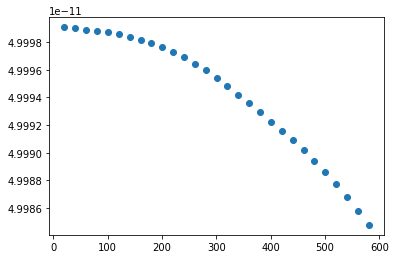

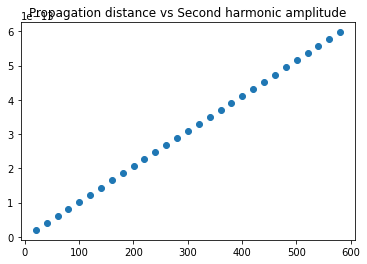

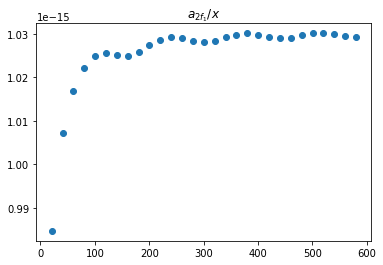

In [50]:
plt.plot(x_detecs_array[0,:], a_f1_at_detecs, marker="o", linestyle="none")
plt.show()

plt.plot(x_detecs_array[0,:],a_2f1_at_detecs, marker="o", linestyle="none")
plt.title("Propagation distance vs Second harmonic amplitude")
plt.savefig("a_2f1.png")
plt.show()

fig, ax=plt.subplots()
ax.set_title("$a_{2f_1}/x$")
ax.plot(x_detecs_array[0,:],a_2f1_at_detecs/x_detecs_array[0,:], marker="o", linestyle="none")
plt.show()


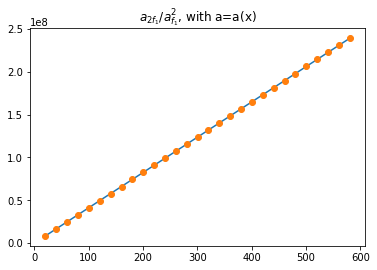

412764.0999265192
2.57841116409445


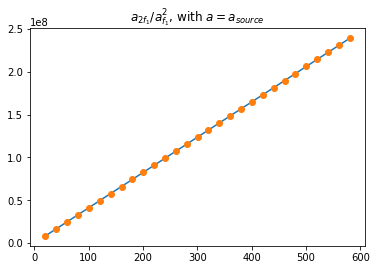

412525.0411037369
2.576917836700796


In [47]:
#slope method
res1 = np.polyfit(x_detecs_array[0,:],a_2f1_at_detecs/a_f1_at_detecs/a_f1_at_detecs,1)
linear = np.poly1d(res1)(x_detecs_array[0,:])
plt.plot(x_detecs_array[0,:],linear)
plt.plot(x_detecs_array[0,:],a_2f1_at_detecs/a_f1_at_detecs/a_f1_at_detecs, marker="o", linestyle="none")
plt.title("$a_{2f_1}/a^2_{f_1}$, with a=a(x)")
plt.show()
print(res1[0])
print(res1[0]*8*wavelength_f1*wavelength_f1*10**10/4/np.pi**2)
beta_slope_corr=res1[0]*8*wavelength_f1*wavelength_f1*10**10/4/np.pi**2

res2 = np.polyfit(x_detecs_array[0,:],a_2f1_at_detecs/a_f1_source/a_f1_source,1)
linear = np.poly1d(res1)(x_detecs_array[0,:])
plt.plot(x_detecs_array[0,:],linear)
plt.plot(x_detecs_array[0,:],a_2f1_at_detecs/a_f1_source/a_f1_source, marker="o", linestyle="none")
plt.title("$a_{2f_1}/a^2_{f_1}$, with $a=a_{source}$")
plt.show()
print(res2[0])
print(res2[0]*8*wavelength_f1*wavelength_f1*10**10/4/np.pi**2)
beta_slope_source=res2[0]*8*wavelength_f1*wavelength_f1*10**10/4/np.pi**2

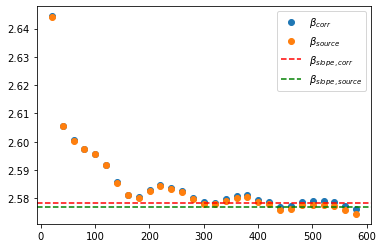

In [48]:
fig, ax = plt.subplots()

ax.plot(x_detecs_array[0,:], betas_at_detecs_corrected, marker="o", linestyle="none", label=r"$\beta _{corr}$")
ax.plot(x_detecs_array[0,:], betas_at_detecs, marker="o", linestyle="none", label=r"$\beta_{source}$")
ax.axhline(y=beta_slope_corr, linestyle="--", color = "red", label=r"$\beta _{slope,corr}$")
ax.axhline(y=beta_slope_source, linestyle="--", color = "green", label=r"$\beta _{slope,source}$")
ax.legend()
plt.show()

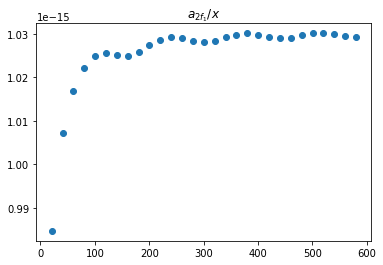

In [49]:
fig, ax=plt.subplots()
ax.set_title("$a_{2f_1}/x$")
ax.plot(x_detecs_array[0,:],a_2f1_at_detecs/x_detecs_array[0,:], marker="o", linestyle="none")
plt.show()